<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Temperature_Dependence_of_CPW_Resonator_Sweeps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
# Environment
!pip install -q --upgrade pip
!pip install -q "scikit-rf>=0.31.1" matplotlib pylint

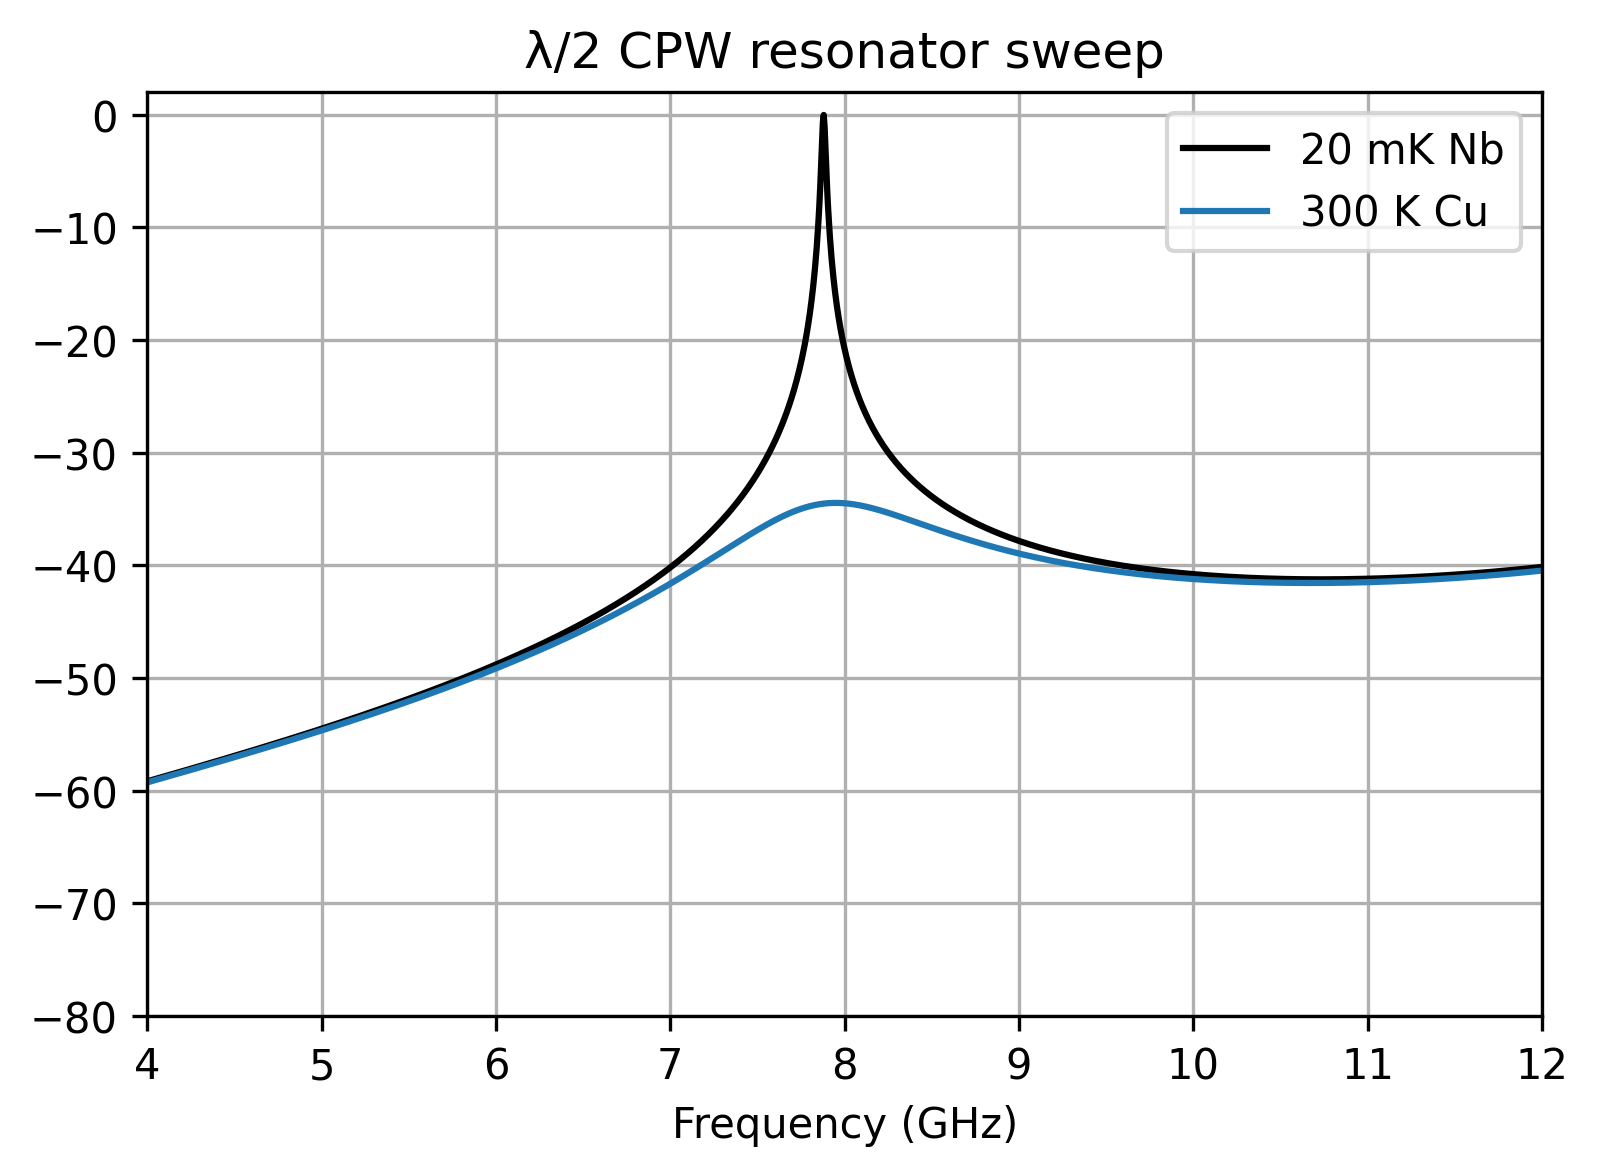

In [91]:
# 300 K vs 20 mK CPW resonator
from skrf import Frequency
from skrf.media import CPW                      # <-- explicit import fixes AttributeError
import numpy as np, matplotlib.pyplot as plt
from scipy.constants import mu_0, pi

plt.rcParams['figure.dpi']  = 300

def mb_surface_resistance(freq_hz, t=0.02, tc=9.2, rho_n=1.5e-9):
    """Toy Mattis–Bardeen Rs (thin-film Nb)."""
    delta = 1.76 * tc * 1.38e-23
    return np.sqrt(mu_0 * (2*pi*freq_hz)**2 * rho_n * (delta/(1.38e-23*t))**2)

freq = Frequency(4, 12, 1601, 'ghz')

cpw_rt = CPW(freq, w=10e-6, s=5e-6, ep_r=11.45,
             rho=1.68e-8, t=180e-9, tand=2e-3)          # Cu, 300 K

cpw_mk = CPW(freq, w=10e-6, s=5e-6, ep_r=11.45,
             rho=1e-20,  t=180e-9, tand=2e-6)           # Nb, 20 mK

def resonator(med, length=7.5e-3, gap_c=20e-15):
    end_gap = med.capacitor(gap_c)
    mid_sec = med.line(length, 'm')
    return end_gap ** mid_sec ** end_gap               # gap–section–gap cascade

rt_net = resonator(cpw_rt)
mk_net = resonator(cpw_mk)

plt.figure(figsize=(6,4))
mk_net.s21.plot_s_db(label='20 mK Nb')
rt_net.s21.plot_s_db(label='300 K Cu')
plt.ylim(-80, 2); plt.grid(); plt.legend(); plt.title('λ/2 CPW resonator sweep');

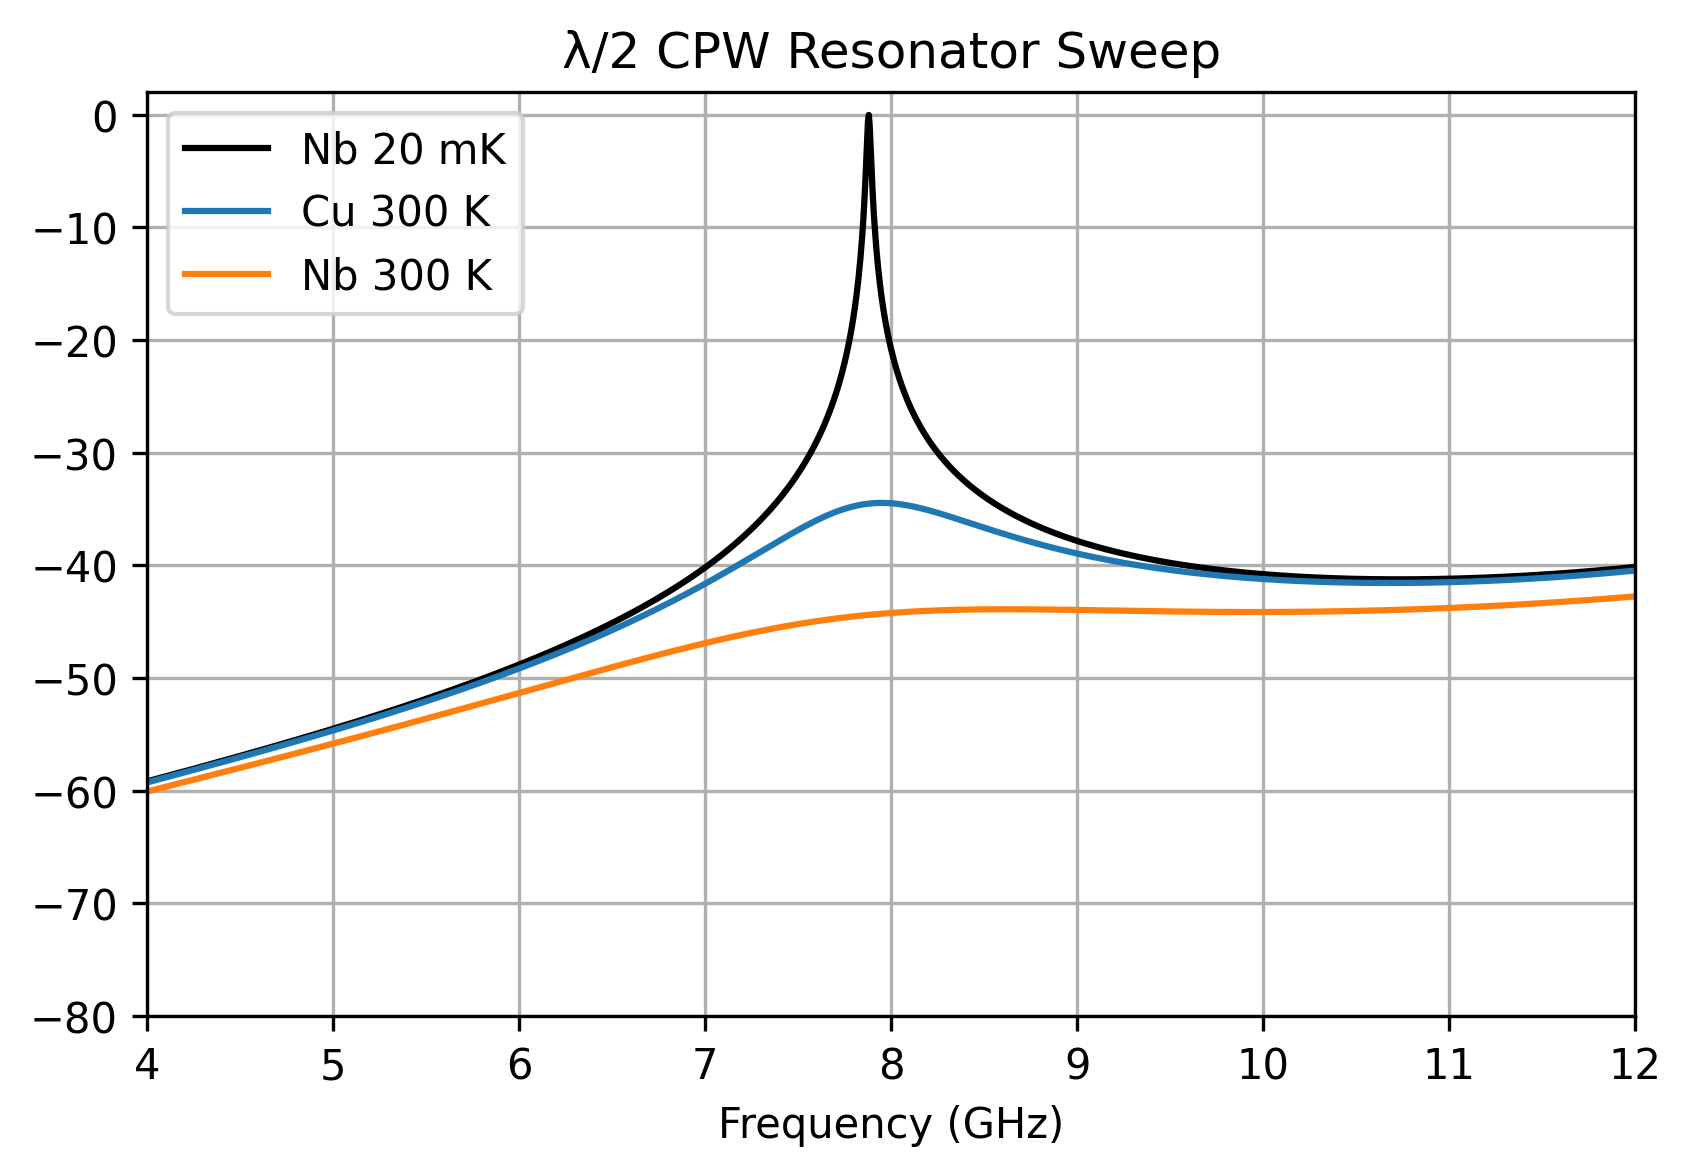

In [92]:
# Cu 300 K  vs  Nb 300 K  vs  Nb 20 mK
from skrf import Frequency
from skrf.media import CPW
import matplotlib.pyplot as plt
import numpy as np

freq = Frequency(4, 12, 1601, 'ghz')

# ----- conductor parameters -------------------------------------------------
rho_Cu_300K = 1.68e-8            # Ω·m  (Cu, CRC Handbook)
rho_Nb_300K = 1.5e-7             # Ω·m  (Nb, room-T)  ← key change!
rho_Nb_20mK = 1e-20              # Ω·m  (approx. superconducting surface)

# ----- CPW media ------------------------------------------------------------
def cpw(rho, name, tand=2e-3):
    return CPW(freq, w=10e-6, s=5e-6, ep_r=11.45,
               rho=rho, t=180e-9, tand=tand, name=name)

cpw_Cu300 = cpw(rho_Cu_300K,  'Cu-300 K')
cpw_Nb300 = cpw(rho_Nb_300K,  'Nb-300 K')
cpw_Nb20m = cpw(rho_Nb_20mK,  'Nb-20 mK', tand=2e-6)   # lower dielectric loss

# ----- resonator helper -----------------------------------------------------
def resonator(med, L=7.5e-3, Cgap=20e-15):
    return med.capacitor(Cgap) ** med.line(L,'m') ** med.capacitor(Cgap)

net_Cu300 = resonator(cpw_Cu300)
net_Nb300 = resonator(cpw_Nb300)
net_Nb20m = resonator(cpw_Nb20m)

# ----- plot -----------------------------------------------------------------
plt.figure(figsize=(6.4,4))
net_Nb20m.s21.plot_s_db(label='Nb 20 mK')
net_Cu300.s21.plot_s_db(label='Cu 300 K')
net_Nb300.s21.plot_s_db(label='Nb 300 K')
plt.ylim(-80,2); plt.grid(True); plt.legend(loc='upper left')
plt.title('λ/2 CPW Resonator Sweep');


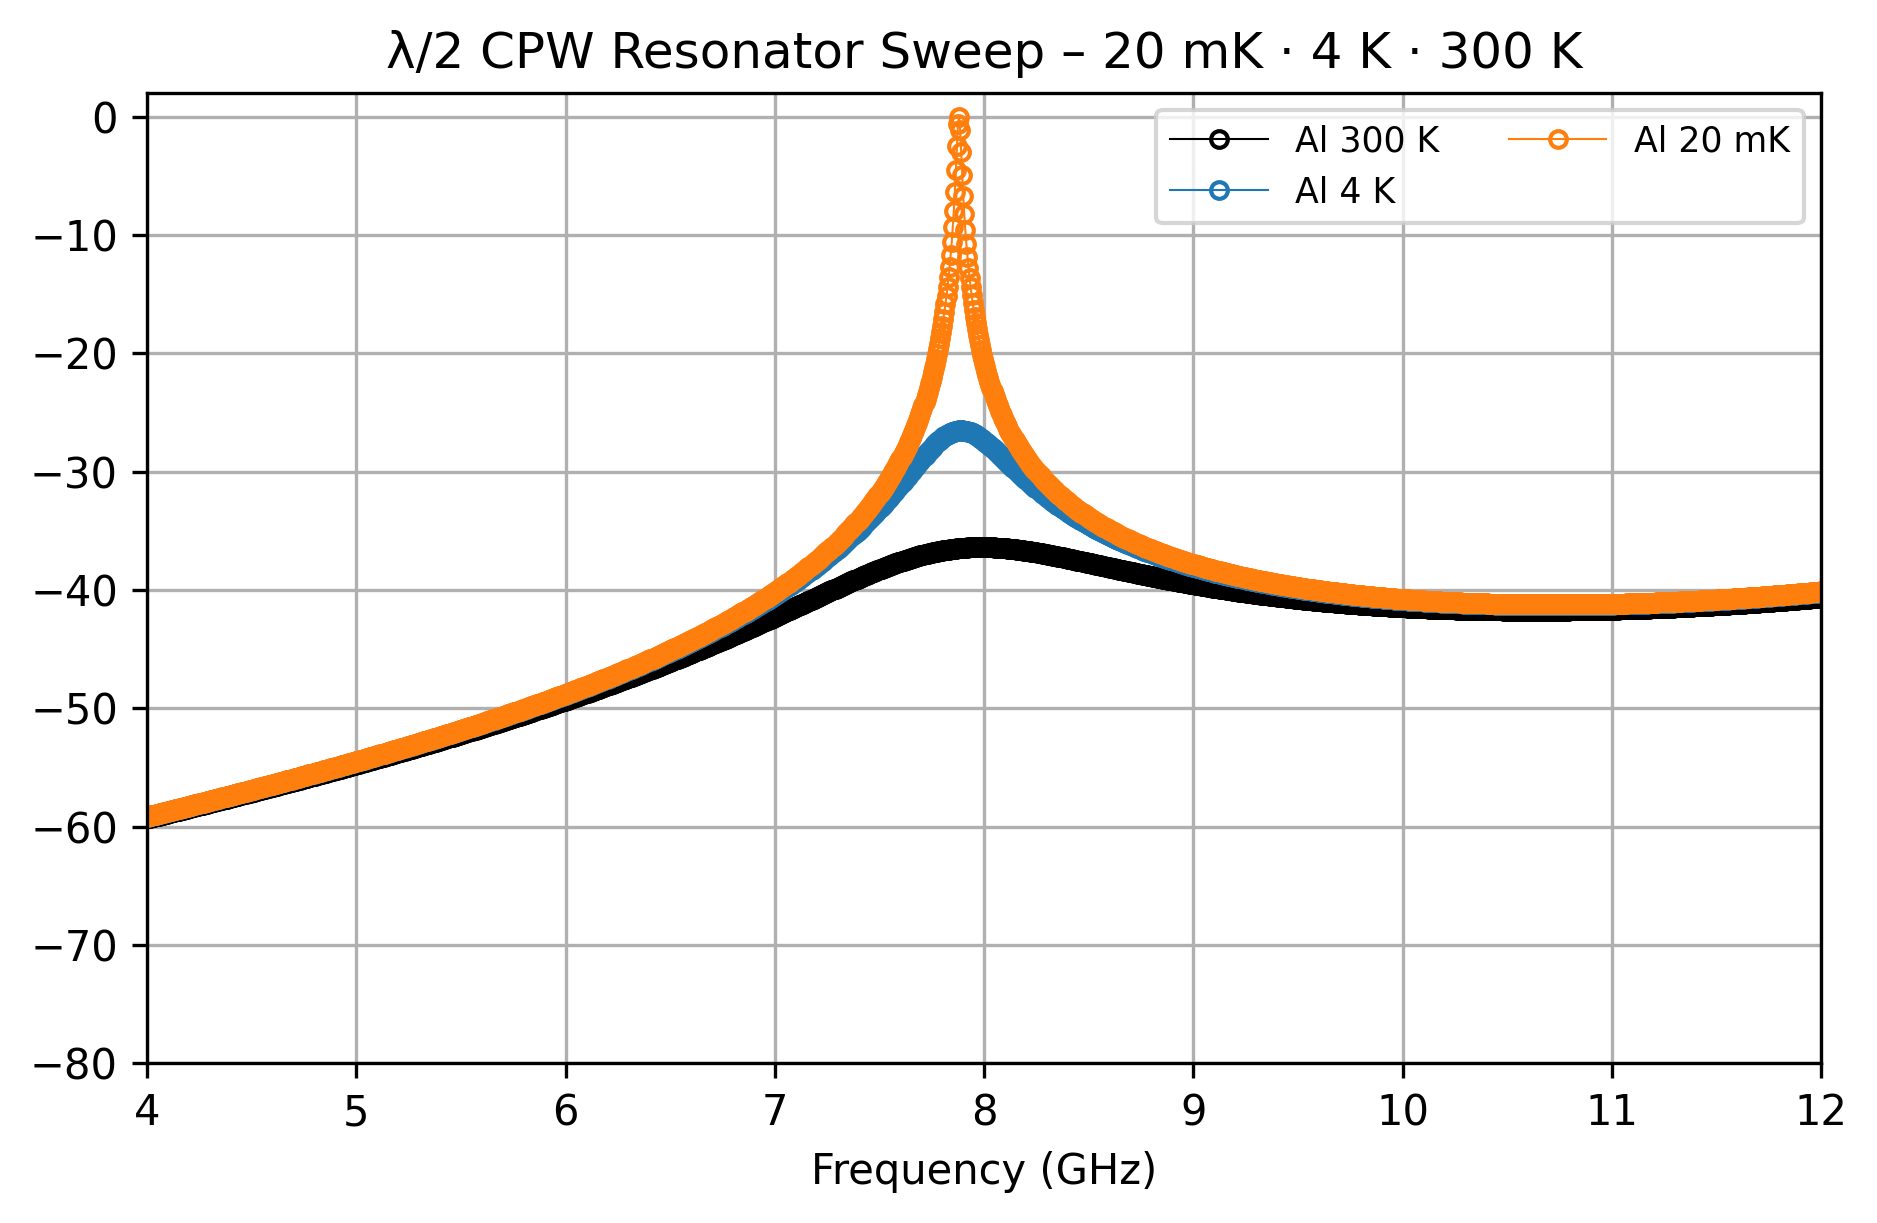

In [93]:
# λ/2 CPW Resonator Sweep (Al)
from skrf.media import CPW
from skrf import Frequency
import matplotlib.pyplot as plt
from cycler import cycler

# ── high-resolution figure & vivid colour cycle ──────────────────────────────
plt.rcParams['axes.prop_cycle'] = cycler(
    'color',
    ['black',
     'tab:blue', 'tab:orange',
     'tab:green','tab:red',
     'tab:purple','tab:brown',
     'tab:pink','blue'])      # nine distinct hues total

# ── microwave band & CPW helpers ─────────────────────────────────────────────
f_band = Frequency(4, 12, 1601, 'ghz')
def cpw(rho, tand=2e-3):
    return CPW(f_band, w=10e-6, s=5e-6, ep_r=11.45,
               rho=rho, t=180e-9, tand=tand)

def resonator(med, L=7.5e-3, C=20e-15):
    return med.capacitor(C) ** med.line(L,'m') ** med.capacitor(C)

# ── resistivity table [Ω m] for Nb, grAl, Al (300 K, 4 K, 20 mK) ────────────
ρ = {
    'Al'  : (2.65e-8, 2.6e-9, 1e-20)                # Al SC below 1.2 K
}

# ── build & plot ─────────────────────────────────────────────────────────────
plt.figure(figsize=(7.2, 4.2))
for metal, (ρ300, ρ4, ρ20) in ρ.items():
    for T, ρT in zip(['300 K', '4 K', '20 mK'], [ρ300, ρ4, ρ20]):
        med  = cpw(ρT, tand=2e-6 if (T != '300 K') else 2e-3)
        net  = resonator(med)
        net.s21.plot_s_db(label=f'{metal} {T}',
                          ls='-', lw=0.5,
                          marker='o', mfc='none', ms=4,
                          mew=1.0)

plt.ylim(-80, 2)
plt.grid(True)
plt.legend(ncol=2, fontsize='small', handlelength=2.8)
plt.title('λ/2 CPW Resonator Sweep – 20 mK · 4 K · 300 K');

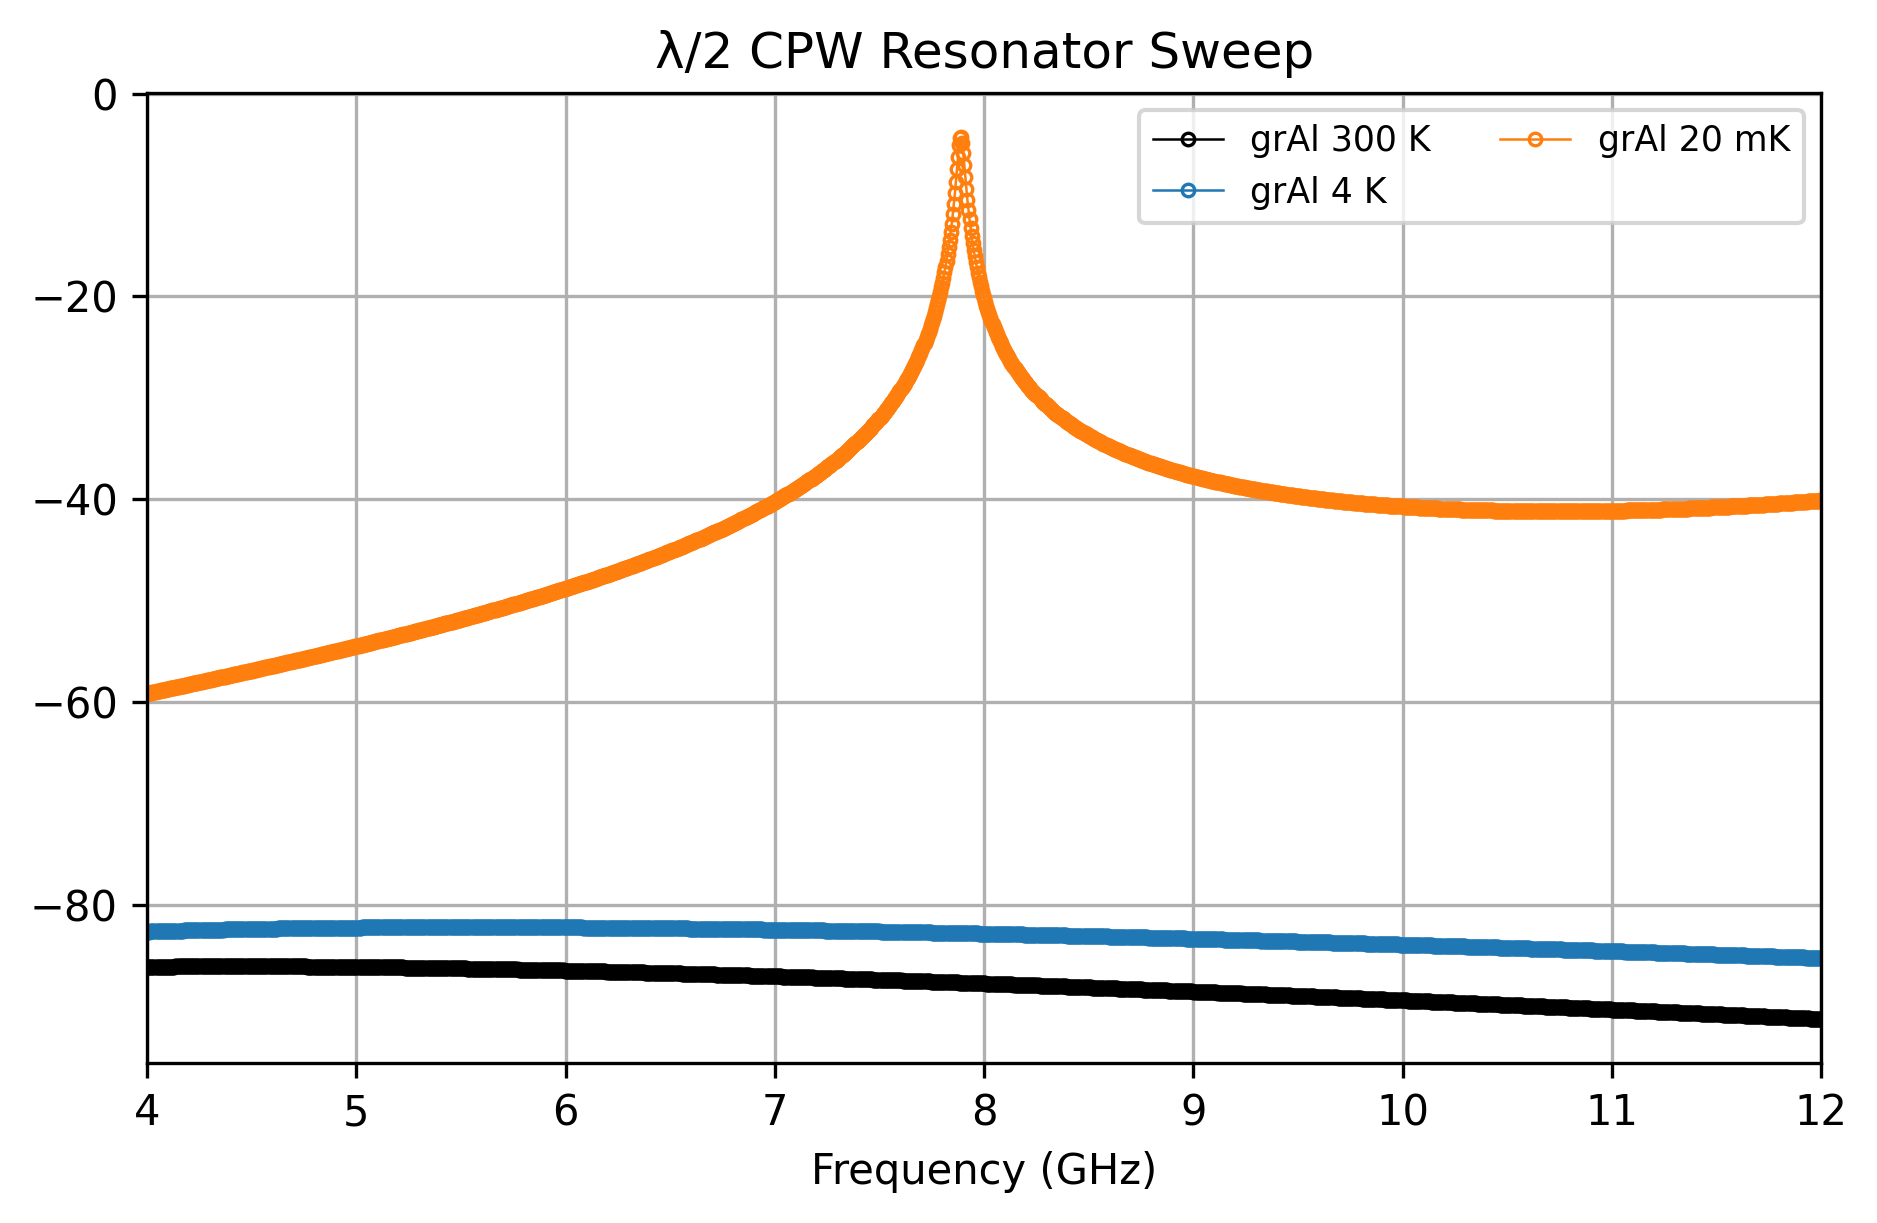

In [94]:
# λ/2 CPW resonator sweep (grAl)
from skrf.media import CPW
from skrf import Frequency
import matplotlib.pyplot as plt, numpy as np

plt.rcParams['axes.prop_cycle'] = plt.cycler(
    color=['black','tab:blue','tab:orange','tab:green',
           'tab:red','tab:purple','tab:brown','tab:pink','blue'])
f_band = Frequency(4, 12, 1601, 'ghz')

def cpw(rho, tand):  # helper
    return CPW(f_band, w=10e-6, s=5e-6, ep_r=11.45, rho=rho, t=180e-9, tand=tand)

ρ = {'grAl': (1.0e-5, 8.0e-6, 1e-20)}
plt.figure(figsize=(7.2,4.2))
for metal, (ρ300,ρ4,ρ20) in ρ.items():
    for T,ρT in zip(['300 K','4 K','20 mK'],[ρ300,ρ4,ρ20]):
        net = (cpw(ρT, 2e-6 if T!='300 K' else 2e-3)
               .capacitor(20e-15) ** cpw(ρT, 2e-3).line(7.5e-3,'m') ** cpw(ρT, 2e-3).capacitor(20e-15))
        net.s21.plot_s_db(label=f'{metal} {T}', ls='-', lw=0.6, marker='o',
                          mfc='none', ms=3, mew=0.8)

ax = plt.gca()
ax.relim(); ax.autoscale_view()
plt.grid(True); plt.legend(fontsize='small', ncol=2)
plt.title('λ/2 CPW Resonator Sweep');


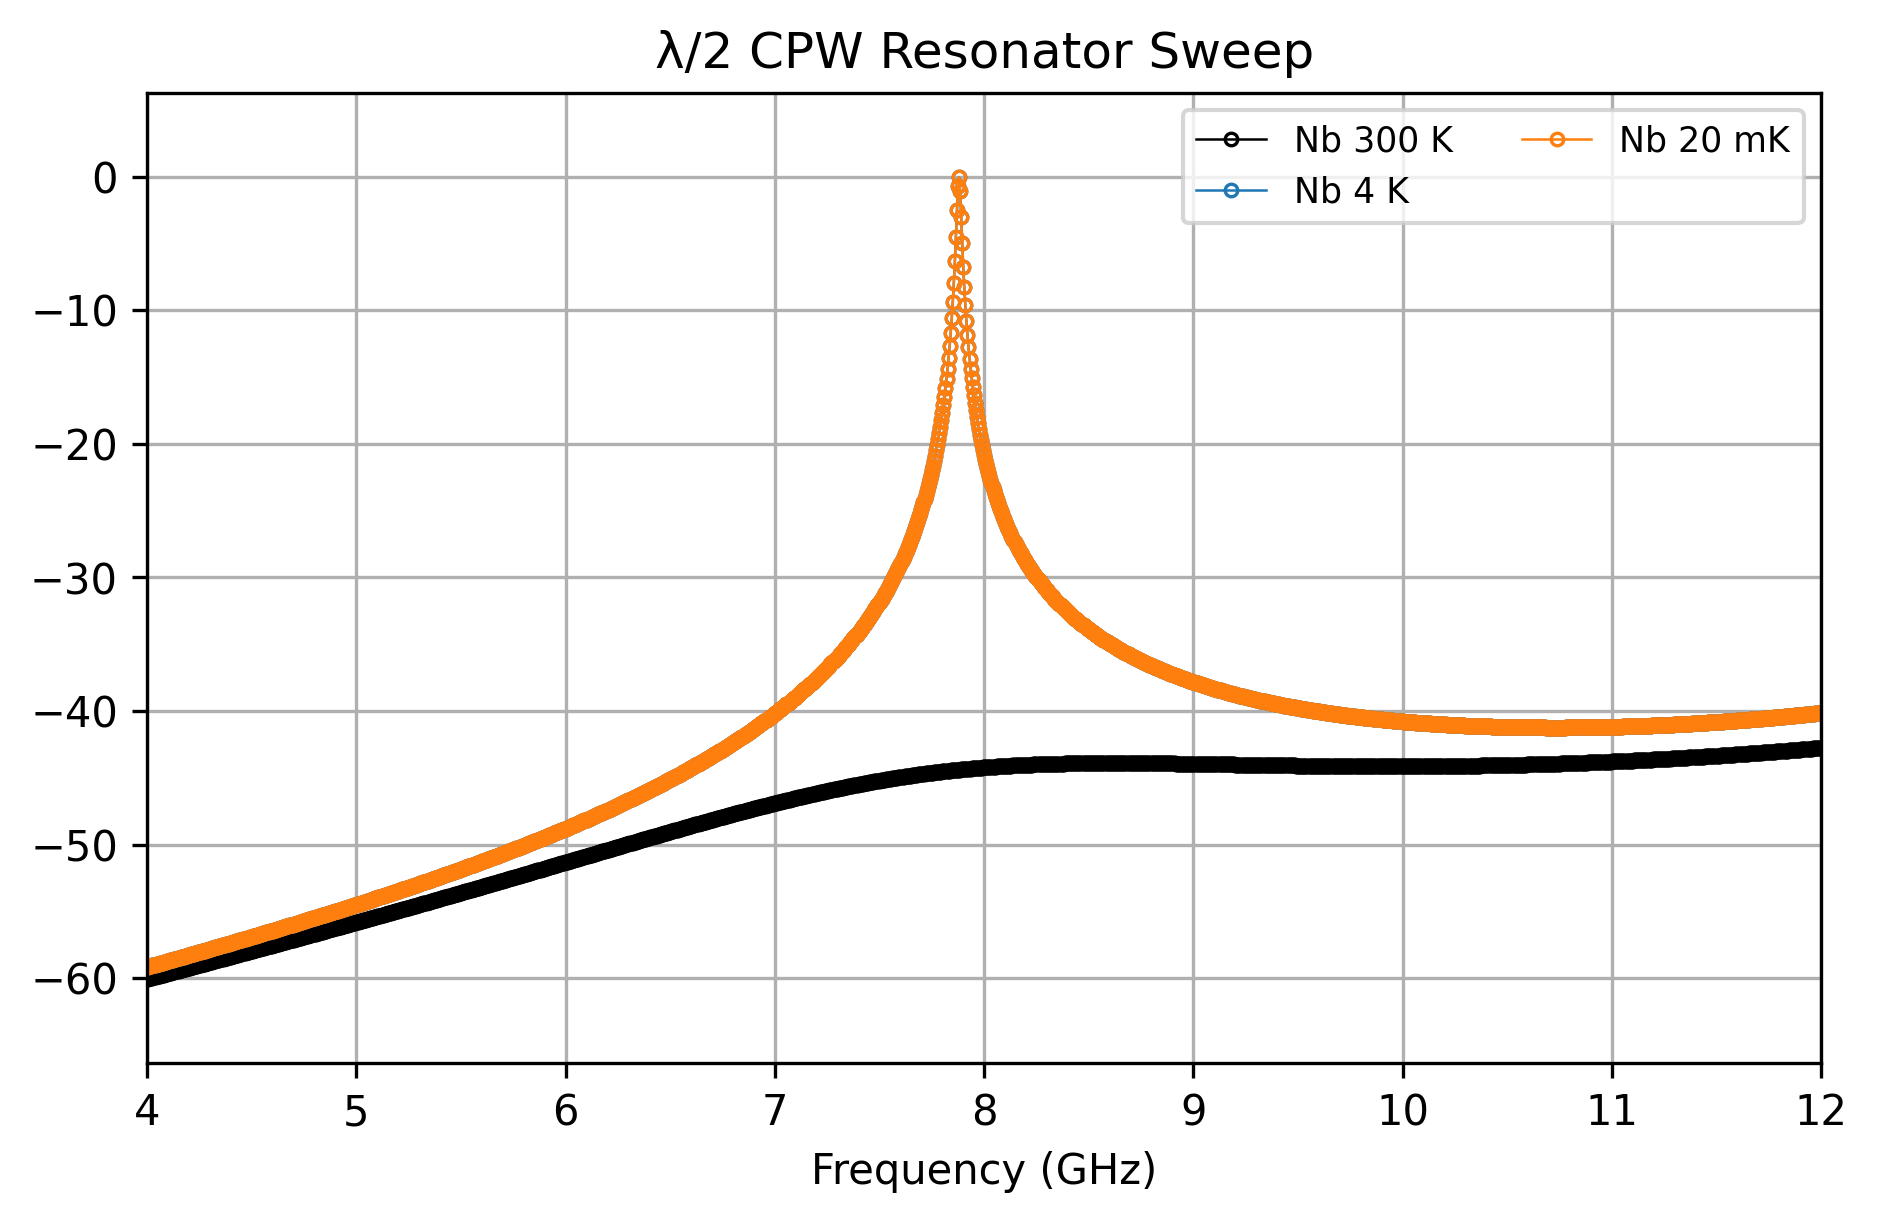

In [95]:
# λ/2 CPW Resonator Sweep (Nb)
from skrf.media import CPW
from skrf import Frequency
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['black','tab:blue','tab:orange','tab:green',
           'tab:red','tab:purple','tab:brown','tab:pink','blue'])

f_band = Frequency(4, 12, 1601, 'ghz')

def cpw(rho, tand):
    return CPW(f_band, w=10e-6, s=5e-6, ep_r=11.45, rho=rho,
               t=180e-9, tand=tand)

def resonator(med, L=7.5e-3, C=20e-15):
    return med.capacitor(C) ** med.line(L,'m') ** med.capacitor(C)

ρ = {'Nb': (1.5e-7, 1e-20, 1e-20)}                 # Nb at 300 K, 4 K, 20 mK

plt.figure(figsize=(7.2, 4.2))
for metal, (ρ300, ρ4, ρ20) in ρ.items():
    for T, ρT in zip(['300 K','4 K','20 mK'], [ρ300, ρ4, ρ20]):
        med = cpw(ρT, tand=2e-6 if T!='300 K' else 2e-3)
        resonator(med).s21.plot_s_db(
            label=f'{metal} {T}', ls='-', lw=0.6,
            marker='o', mfc='none', ms=3, mew=0.8)

ax = plt.gca()
ax.relim()
ax.autoscale_view()
bottom, top = ax.get_ylim()
padding = 0.05*(top - bottom)
ax.set_ylim(bottom - padding, top + padding)

plt.grid(True)
plt.legend(ncol=2, fontsize='small')
plt.title('λ/2 CPW Resonator Sweep');

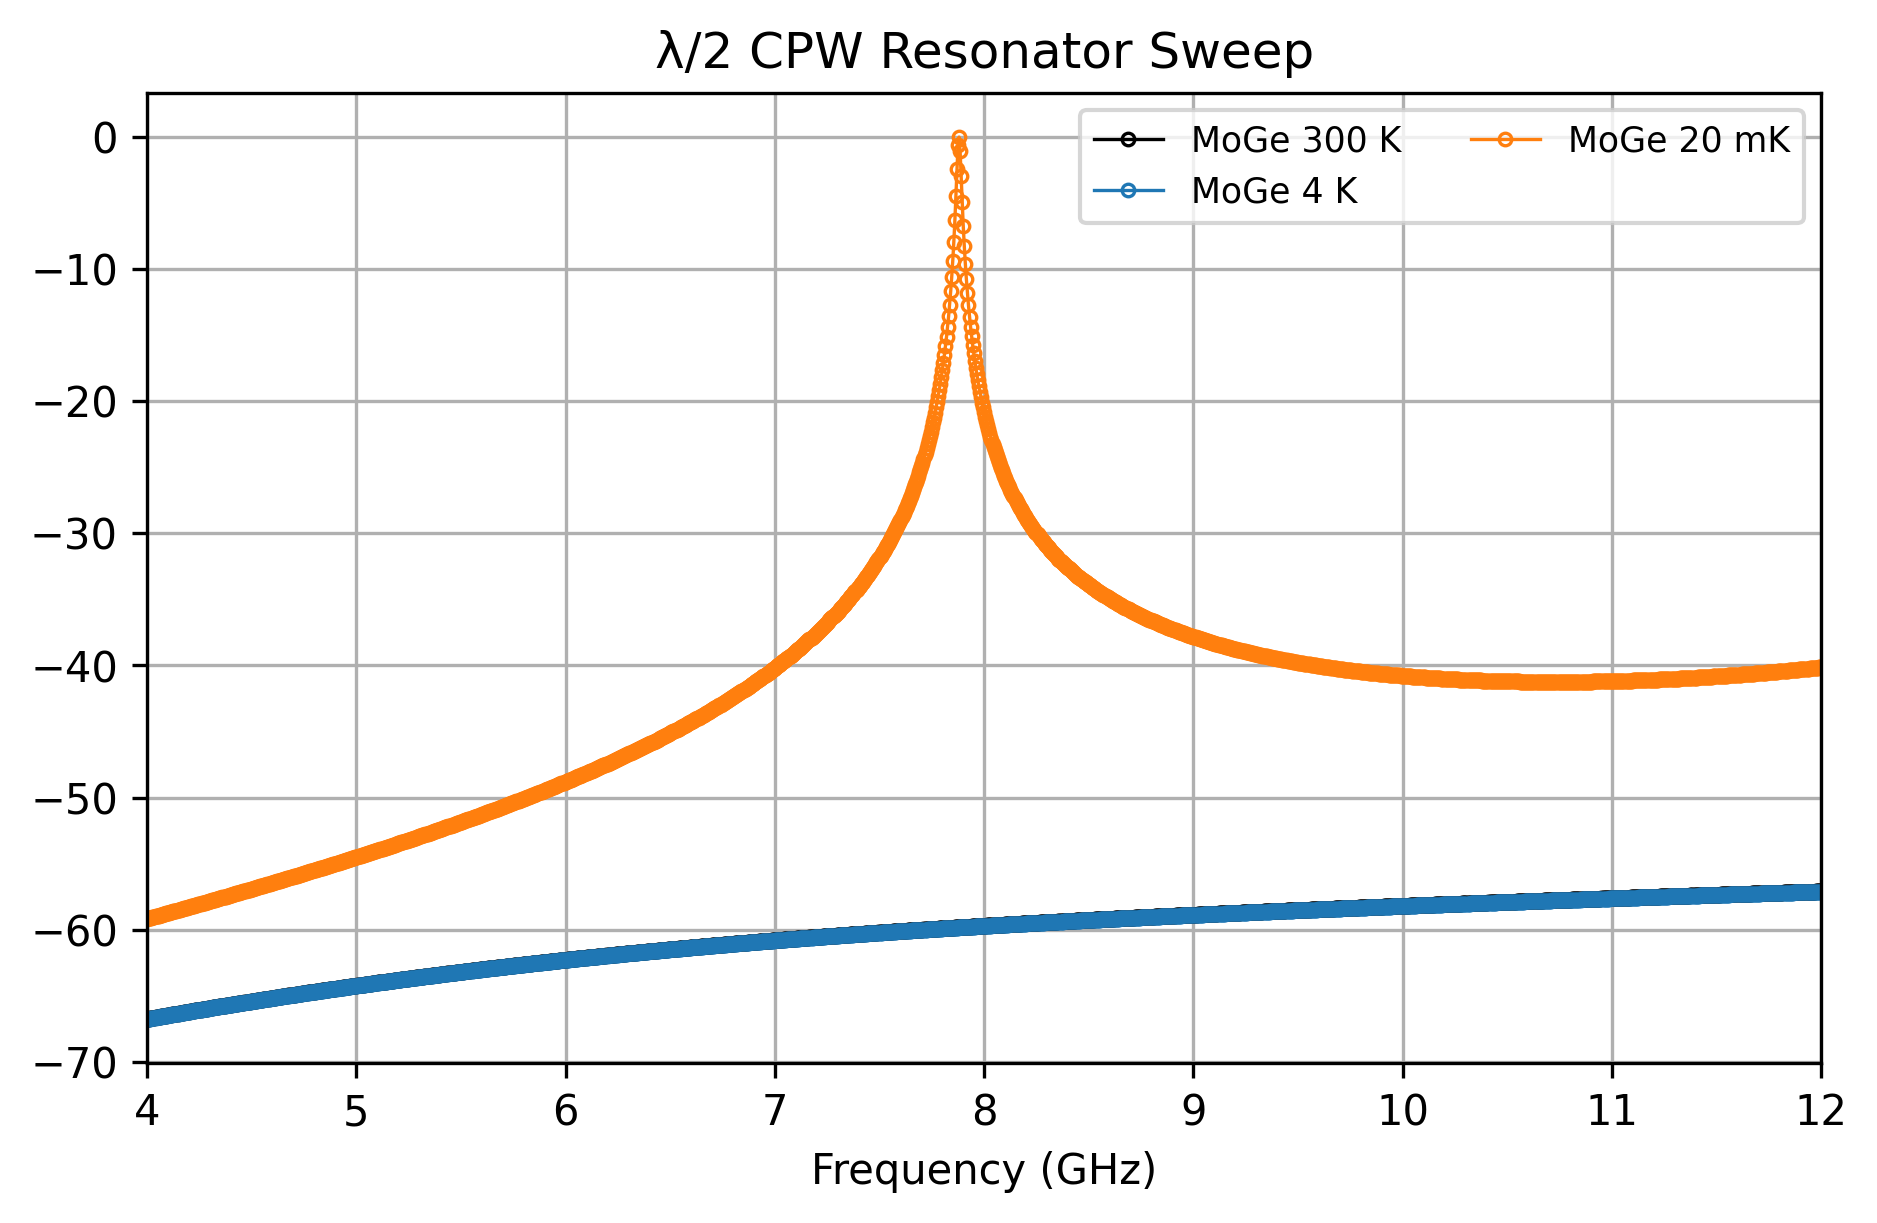

In [97]:
# Cell — λ/2 CPW resonator sweep (MoGe)
from skrf.media import CPW
from skrf import Frequency
import matplotlib.pyplot as plt
from cycler import cycler

# ── global style ─────────────────────────────────────────────────────────────
plt.rcParams['axes.prop_cycle'] = cycler(
    color=['black','tab:blue','tab:orange','tab:green',
           'tab:red','tab:purple','tab:brown','tab:pink','blue'])

# ── microwave band & helpers ─────────────────────────────────────────────────
f_band = Frequency(4, 12, 1601, "ghz")

def cpw(rho, tand):
    return CPW(f_band, w=10e-6, s=5e-6, ep_r=11.45,
               rho=rho, t=180e-9, tand=tand)

def λ2_resonator(medium, L=7.5e-3, Cgap=20e-15):
    return medium.capacitor(Cgap) ** medium.line(L,"m") ** medium.capacitor(Cgap)

# ── resistivity table ρ(T)  [Ω·m]  (300 K, 4 K, 20 mK) ──────────────────────
ρ = {
    "MoGe": (1.60e-6 , 1.60e-6, 1.0e-20)           # a-MoGe ρ ≈ 160 µΩ cm
                                                   # Tc ≈ 6.8 K so 4 K & 20 mK are SC
}

# ── build & plot ─────────────────────────────────────────────────────────────
plt.figure(figsize=(7.2,4.2))
for metal, (ρ300, ρ4, ρ20) in ρ.items():
    for T, ρT in zip(["300 K","4 K","20 mK"], [ρ300, ρ4, ρ20]):
        medium = cpw(ρT, tand = 2e-6 if T!="300 K" else 2e-3)
        λ2_resonator(medium).s21.plot_s_db(
            label=f"{metal} {T}",
            ls="-", lw=0.8,
            marker="o", mfc="none", ms=3, mew=0.8)

# ── automatic y-lim with 5 % padding ────────────────────────────────────────
plt.grid(True)
plt.legend(ncol=2, fontsize='small')
plt.title('λ/2 CPW Resonator Sweep');